In [1]:
!nvidia-smi

Sun Mar 19 05:09:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
ROOT = "/content/drive/MyDrive/AI_Project/200 Bird Species dataset"


In [7]:
data_dir = ROOT
train_dir = "/content/drive/MyDrive/AI_Project/200 Bird Species dataset/Train"
test_dir = "/content/drive/MyDrive/AI_Project/200 Bird Species dataset/Test"

In [8]:
#train_data = datasets.ImageFolder(root = train_dir, 
 #                                 transform = transforms.ToTensor())

#means = torch.zeros(3)
#stds = torch.zeros(3)

#for img, label in train_data:
 #   means += torch.mean(img, dim = (1,2))
  #  stds += torch.std(img, dim = (1,2))

#means /= len(train_data)
#stds /= len(train_data)
    
#print(f'Calculated means: {means}')
#print(f'Calculated stds: {stds}')

KeyboardInterrupt: ignored

In [9]:
pretrained_size = 224
pretrained_means = [0.4909, 0.5135, 0.4679]
pretrained_stds= [0.1804, 0.1800, 0.1916]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [10]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

In [11]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [12]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [13]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 2475
Number of validation examples: 275
Number of testing examples: 250


In [14]:
BATCH_SIZE = 5

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [15]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image 

In [16]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

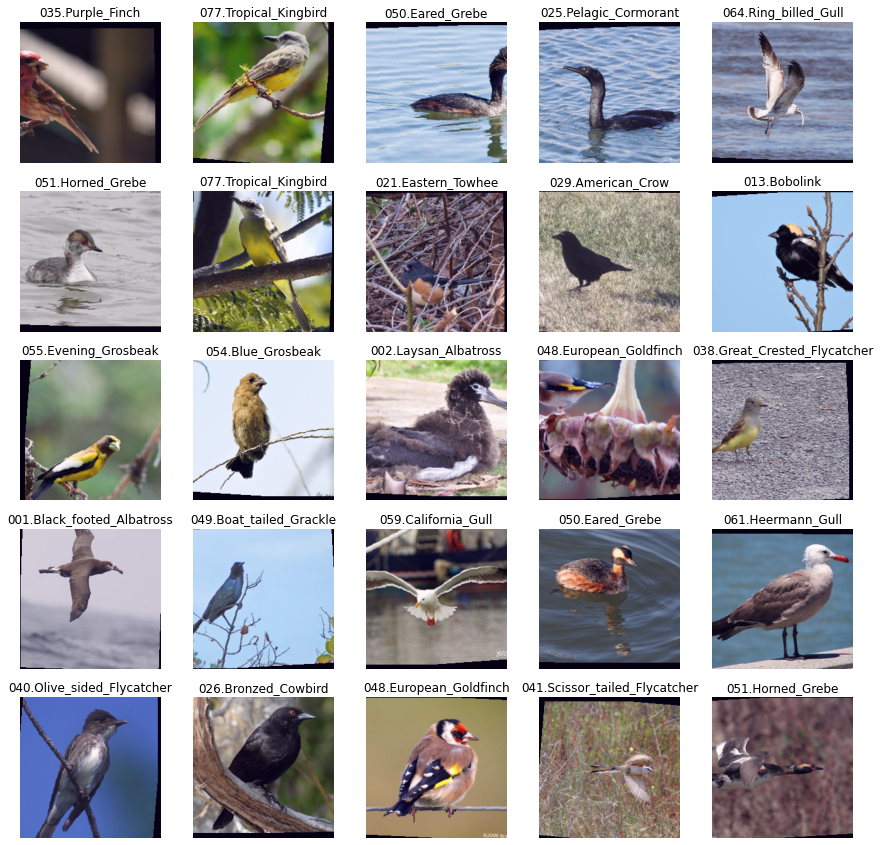

In [17]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [18]:
def format_label(label):
    label = label.split('.')[-1]
    label = label.replace('_', ' ')
    label = label.title()
    label = label.replace(' ', '')
    return label

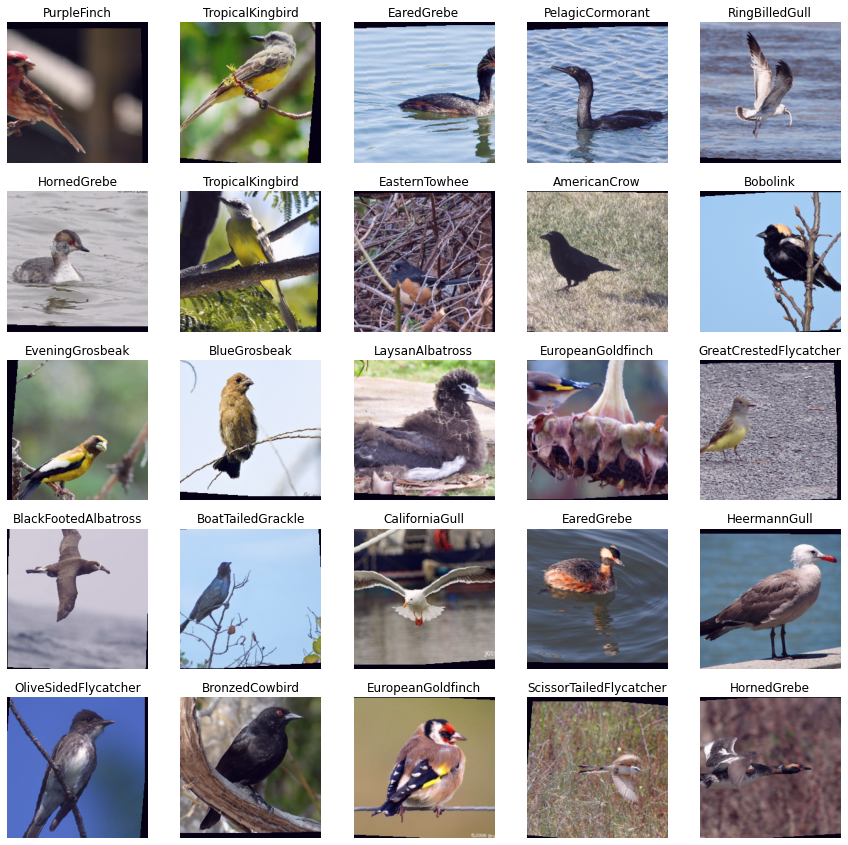

In [19]:
test_data.classes = [format_label(c) for c in test_data.classes]

classes = test_data.classes

plot_images(images, labels, classes)

In [20]:
import torch
import torch.nn as nn
from functools import reduce

In [21]:
def Conv3x3BN(in_channels,out_channels,stride=1,groups=1):
    return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, groups=groups),
            nn.BatchNorm2d(out_channels)
        )

def Conv3x3BNReLU(in_channels,out_channels,stride=1,groups=1):
    return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, groups=groups),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(inplace=True)
        )

def Conv1x1BN(in_channels,out_channels):
    return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels)
        )

def Conv1x1BNReLU(in_channels,out_channels):
    return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(inplace=True)
        )

In [22]:
class SandglassBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion_factor=6):
        super(SandglassBlock, self).__init__()
        self.stride = stride
        mid_channels = in_channels // expansion_factor
        self.identity = stride == 1 and in_channels == out_channels

        self.bottleneck = nn.Sequential(
            Conv3x3BNReLU(in_channels, in_channels, 1, groups=in_channels),
            Conv1x1BN(in_channels, mid_channels),
            Conv1x1BNReLU(mid_channels, out_channels),
            Conv3x3BN(out_channels, out_channels, stride, groups=out_channels),
        )

    def forward(self, x):
        out = self.bottleneck(x)
        if self.identity:
            return out + x
        else:
            return out

In [23]:
class MobileNetXt(nn.Module):
    def __init__(self, num_classes=1000):
        super(MobileNetXt,self).__init__()

        self.first_conv = Conv3x3BNReLU(3,32,2,groups=1)

        self.layer1 = self.make_layer(in_channels=32, out_channels=96, stride=2, expansion_factor=2, block_num=1)
        self.layer2 = self.make_layer(in_channels=96, out_channels=144, stride=1, expansion_factor=6, block_num=1)
        self.layer3 = self.make_layer(in_channels=144, out_channels=192, stride=2, expansion_factor=6, block_num=3)
        self.layer4 = self.make_layer(in_channels=192, out_channels=288, stride=2, expansion_factor=6, block_num=3)
        self.layer5 = self.make_layer(in_channels=288, out_channels=384, stride=1, expansion_factor=6, block_num=4)
        self.layer6 = self.make_layer(in_channels=384, out_channels=576, stride=2, expansion_factor=6, block_num=4)
        self.layer7 = self.make_layer(in_channels=576, out_channels=960, stride=1, expansion_factor=6, block_num=2)
        self.layer8 = self.make_layer(in_channels=960, out_channels=1280, stride=1, expansion_factor=6, block_num=1)

        self.avgpool = nn.AvgPool2d(kernel_size=7,stride=1)
        self.dropout = nn.Dropout(p=0.2)
        self.linear = nn.Linear(in_features=1280,out_features=num_classes)

    def make_layer(self, in_channels, out_channels, stride, expansion_factor, block_num):
        layers = []
        layers.append(SandglassBlock(in_channels, out_channels, stride,expansion_factor))
        for i in range(1, block_num):
            layers.append(SandglassBlock(out_channels,out_channels,1,expansion_factor))
        return nn.Sequential(*layers)

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear) or isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.first_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x = self.dropout(x)
        out = self.linear(x)
        return out


if __name__=='__main__':
    model = MobileNetXt()
    # print(model)

    # input = torch.randn(1, 3, 224, 224)
    # out = model(input)
    # print(out.shape)

In [24]:
MobileNetConfig = namedtuple('MobileNetConfig', ['block', 'n_blocks', 'channels'])

In [25]:
mobilenet_config = MobileNetConfig(block = SandglassBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])


In [26]:
import torch
import torchvision.models as models

pretrained_model = models.mobilenet_v2(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [27]:
IN_FEATURES = pretrained_model.classifier[1].in_features
OUTPUT_DIM = len(test_data.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.classifier[1] = fc

In [28]:
pretrained_model.fc = fc

In [29]:
model_dict = pretrained_model.fc.state_dict()
model_dict = {k: v for k, v in model_dict.items() if k in ['weight', 'bias']}
pretrained_model.fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc.load_state_dict(model_dict)
#pretrained_model.fc = {k: v for k, v in pretrained_model.fc.items() if k in model_dict}

<All keys matched successfully>

In [30]:
model = MobileNetXt(num_classes=15)

In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,739,575 trainable parameters


In [32]:
#TRAINING THE MODEL

START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [33]:
#Finding Ideal Learning rate

class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 1, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        #y_pred = self.model(x)
        y_pred= self._train_batch(iterator)

        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()
        return self.model(x)

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)
     


In [34]:
import torch
torch.cuda.empty_cache()

In [35]:
import torch

torch.cuda.is_available()

True

In [36]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
END_LR = 1
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)